In [1]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import ale_py  as ale
from PIL import Image
from collections import deque
import os
from torch.utils.tensorboard import SummaryWriter
from tqdm import trange
from datetime import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [29]:
env = gym.make("Breakout-v4", render_mode="rgb_array",frameskip=5)


frame, info= env.reset()
# plt.imshow(frame[0])
# plt.axis('off')
frame   

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], shape=(210, 160, 3), dtype=uint8)

In [30]:
def preprocess_and_resize(frame):
    gray = 0.299 * frame[:, :, 0] \
         + 0.587 * frame[:, :, 1] \
         + 0.114 * frame[:, :, 2]
    gray = gray.astype(np.uint8)

    img = Image.fromarray(gray)
    img = img.resize((84, 84), Image.BILINEAR)

    return np.array(img, dtype=np.float32) / 255.0

def stack_frames(stacked_frames, frame, is_new_episode, stack_size=4):
    resized_frame = preprocess_and_resize(frame)
        
    if is_new_episode:
        stacked_frames = deque([np.zeros((84, 84), dtype=np.float32) for _ in range(stack_size)], maxlen=stack_size)
        for _ in range(stack_size):
            stacked_frames.append(resized_frame)
    else:
        stacked_frames.append(resized_frame)
    
    stacked_state = np.stack(stacked_frames, axis=0)
    return stacked_state, stacked_frames

(84, 84)

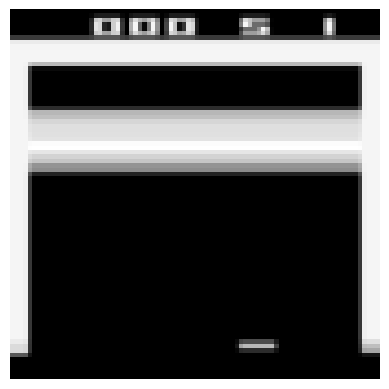

In [31]:
p_frame = preprocess_and_resize(frame)
plt.imshow(p_frame, cmap='gray')
plt.axis('off')
p_frame.shape

In [32]:
stacked_state, stacked_frames = stack_frames(deque(), frame, True)
stacked_state.shape

(4, 84, 84)

In [33]:
class DQN(nn.Module):
    def __init__(self, input_channels, num_actions):
        super().__init__()

        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        self.fc1 = nn.Linear(7 * 7 * 64, 512)
        self.fc2 = nn.Linear(512, num_actions)

    def forward(self, x):
        x = x / 1.0  # no-op, but makes intent explicit

        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [34]:
class ReplayBuffer:
    def __init__(self, buffer_size):
        self.buffer_size = buffer_size
        self.buffer = deque(maxlen=buffer_size)
    
    def add(self, experience):
        self.buffer.append(experience)
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def size(self):
        return len(self.buffer)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    

def epsilon_greedy_action_selection(state, policy_net, epsilon, num_actions):
    if random.random() < epsilon:
        return random.randint(0, num_actions - 1)
    else:
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        with torch.no_grad():
            q_values = policy_net(state)
        return q_values.argmax().item()

In [36]:
env = gym.make("Breakout-v4", render_mode="rgb_array",frameskip=5)

frame, info= env.reset()

In [37]:
import copy 
num_actions = env.action_space.n
q_net = DQN(input_channels=4, num_actions=num_actions)
# Assuming q_net is your main Q-network
target_net = copy.deepcopy(q_net)
target_net.eval()  # Target net is only used for inference


# Move networks to device first
q_net.to(device)
target_net.to(device)

# state, stacked_frames = stack_frames(None, frame, True)
# state_tensor = torch.from_numpy(state).unsqueeze(0)  # (1, 4, 84, 84)
# state_tensor = state_tensor.float()

# with torch.no_grad():
#     q_values = q_net(state_tensor)

# print(q_values.shape)


DQN(
  (conv1): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=3136, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)

In [40]:
os.makedirs("checkpoints", exist_ok=True)
episodes = 10000
batch_size = 64
epsilon = 1.0
epsilon_decay = 0.9955
min_epsilon = 0.1
gamma = 0.995
lr = 0.1e3
buffer_size=1000000
target_update_freq = 2000  # update target net every 1000 steps

optimizer = optim.Adam(q_net.parameters(), lr=lr)
buffer = ReplayBuffer(buffer_size=10000)

In [ ]:
run_id = datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter(f"runs/pacman_dqn/{run_id}")

global_step = 0
loss_ma = 0  # moving average of loss
# assign tqdm object
pbar = trange(episodes, desc="Episodes", unit="ep", leave=False)
for episode in pbar:
    frame, info = env.reset()
    state, stacked_frames = stack_frames(None, frame, True)
    done = False
    total_reward = 0
    step = 0

    episode_loss = 0.0
    episode_q_mean = 0.0
    episode_q_max = 0.0
    episode_grad_norm = 0.0
    train_steps = 0


    while not done:
        action = epsilon_greedy_action_selection(state, q_net, epsilon, num_actions)

        next_frame, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated

        next_state, stacked_frames = stack_frames(stacked_frames, next_frame, False)

        # Replay buffer
        experience = (state, action, reward, next_state, done)
        buffer.add(experience=experience)

        # --- TD loss step ---
        if buffer.size() > batch_size:
            batch = buffer.sample(batch_size)

            states = torch.FloatTensor(np.array([exp[0] for exp in batch])).to(device)
            actions = torch.LongTensor(np.array([exp[1] for exp in batch])).to(device)
            rewards = torch.FloatTensor(np.array([exp[2] for exp in batch])).to(device)
            next_states = torch.FloatTensor(np.array([exp[3] for exp in batch])).to(device)
            dones = torch.FloatTensor([float(exp[4]) for exp in batch]).to(device)

            # Current Q-values
            q_values_all = q_net(states)
            q_values = q_values_all.gather(1, actions.unsqueeze(1)).squeeze(1)

            # Target Q-values
            with torch.no_grad():
                next_actions = q_net(next_states).argmax(dim=1)
                
                next_q_values = target_net(next_states).gather(
                    1, next_actions.unsqueeze(1)
                ).squeeze(1)
                target = rewards + gamma * next_q_values * (1 - dones)

            # Loss
            loss = F.smooth_l1_loss(q_values, target)

            # Backprop
            optimizer.zero_grad()
            loss.backward()

            # Optional: gradient norm
            grad_norm = 0
            for param in q_net.parameters():
                if param.grad is not None:
                    grad_norm += param.grad.data.norm(2).item() ** 2
            grad_norm = grad_norm ** 0.5

            optimizer.step()

            # Moving average of loss
            loss_ma = 0.99 * loss_ma + 0.01 * loss.item()

            # --- TensorBoard logging ---
            # Accumulate episode stats
            episode_loss += loss.item()
            episode_q_mean += q_values.mean().item()
            episode_q_max += q_values.max().item()
            episode_grad_norm += grad_norm
            train_steps += 1

            global_step += 1
            if global_step % target_update_freq == 0:
                target_net.load_state_dict(q_net.state_dict())

        # -------------------

        state = next_state
        total_reward += reward
        step += 1

    # Optional: decay epsilon here
    epsilon = max(min_epsilon, epsilon * epsilon_decay)

    # Dynamically update metrics inline
    pbar.set_postfix({
        "Reward": total_reward,
        "Steps": step,
        "Epsilon": f"{epsilon:.3f}"
    })
    if train_steps > 0:  # buffer was warm, training actually happened
        writer.add_scalar("Episode/total_reward", total_reward, episode)
        writer.add_scalar("Episode/length", step, episode)
        writer.add_scalar("Episode/mean_td_loss", episode_loss / train_steps, episode)
        writer.add_scalar("Episode/mean_q", episode_q_mean / train_steps, episode)
        writer.add_scalar("Episode/max_q", episode_q_max / train_steps, episode)
        writer.add_scalar("Episode/mean_grad_norm", episode_grad_norm / train_steps, episode)
        writer.add_scalar("Episode/epsilon", epsilon, episode)


    if (episode + 1) % 250 == 0:
        checkpoint = {
            "episode": episode + 1,
            "q_net_state": q_net.state_dict(),
            "target_net_state": target_net.state_dict(),
            "optimizer_state": optimizer.state_dict(),
            "epsilon": epsilon,
            "global_step": global_step
        }
        torch.save(checkpoint, f"checkpoints/pacman_dqn_ep{episode+1}.pth")



writer.close()


Episodes:   2%|▏         | 169/10000 [07:42<7:27:23,  2.73s/ep, Reward=2, Steps=202, Epsilon=0.467]

In [ ]:
def load_checkpoint(path, q_net, target_net, optimizer, device="cuda"):
    checkpoint = torch.load(path, map_location=device)

    q_net.load_state_dict(checkpoint["q_net"])
    target_net.load_state_dict(checkpoint["target_net"])
    optimizer.load_state_dict(checkpoint["optimizer"])

    return (
        checkpoint["episode"],
        checkpoint["epsilon"],
        checkpoint["step_count"]
    )


In [17]:
import torch

checkpoint_path = "checkpoints/pacman_dqn_ep250.pth"  # change as needed
device = "cuda" if torch.cuda.is_available() else "cpu"
checkpoint = torch.load(checkpoint_path, map_location=device)

q_net.load_state_dict(checkpoint["q_net_state"])
target_net.load_state_dict(checkpoint["target_net_state"])
optimizer.load_state_dict(checkpoint["optimizer_state"])

start_episode = checkpoint["episode"]
epsilon = checkpoint["epsilon"]
global_step = checkpoint["global_step"]

print(f"Resumed from episode {start_episode}")
print(f"Epsilon: {epsilon:.4f}, Global step: {global_step}")


Resumed from episode 250
Epsilon: 0.8825, Global step: 107916


C:\Users\91930\AppData\Local\Temp\ipykernel_3516\3579235307.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)

In [14]:
with torch.no_grad():
    dummy = torch.zeros(1, 4, 84, 84).to(device)  # batch=1
    q = q_net(dummy)
    print(q, q.shape)


tensor([[-521.1310, -495.9741, -482.5642, -496.4282, -464.8993, -588.1917,
         -500.2617, -494.8692, -473.5265]], device='cuda:0') torch.Size([1, 9])


In [23]:
def evaluate_agent(
    env,
    q_net,
    num_episodes=10,
    render=False,
    device="cpu"
):
    q_net.eval()          # important
    rewards = []
    lengths = []

    with torch.no_grad(): # absolutely critical
        for ep in range(num_episodes):
            frame, info = env.reset()
            state, stacked_frames = stack_frames(None, frame, True)

            done = False
            ep_reward = 0
            steps = 0

            while not done:
                state_t = (
                    torch.from_numpy(state)
                    .unsqueeze(0)
                    .float()
                    .to(device)
                )

                # action = q_net(state_t).argmax(dim=1).item()
                action = epsilon_greedy_action_selection(
                    state, q_net, epsilon=0.3, num_actions=env.action_space.n
                )

                next_frame, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated

                state, stacked_frames = stack_frames(
                    stacked_frames, next_frame, False
                )

                ep_reward += reward
                steps += 1

                if render:
                    env.render()

            rewards.append(ep_reward)
            lengths.append(steps)
            print(f"[EVAL] Ep {ep+1:02d} | Reward {ep_reward:4.1f} | Steps {steps}")

    q_net.train()  # restore mode for later training

    print(
        f"\n[EVAL SUMMARY] "
        f"mean={np.mean(rewards):.2f}, "
        f"max={np.max(rewards):.1f}, "
        f"std={np.std(rewards):.2f}"
    )

    return rewards, lengths


In [25]:
eval_env = gym.make("MsPacman-v4", render_mode="rgb_array",frameskip=5)


evaluate_agent(
    eval_env,
    q_net,
    num_episodes=10,
    render=False,
    device=device
)


[EVAL] Ep 01 | Reward 280.0 | Steps 313
[EVAL] Ep 02 | Reward 270.0 | Steps 473
[EVAL] Ep 03 | Reward 340.0 | Steps 660
[EVAL] Ep 04 | Reward 220.0 | Steps 396
[EVAL] Ep 05 | Reward 180.0 | Steps 386
[EVAL] Ep 06 | Reward 370.0 | Steps 565
[EVAL] Ep 07 | Reward 250.0 | Steps 449
[EVAL] Ep 08 | Reward 380.0 | Steps 607
[EVAL] Ep 09 | Reward 560.0 | Steps 721
[EVAL] Ep 10 | Reward 380.0 | Steps 452

[EVAL SUMMARY] mean=323.00, max=560.0, std=103.06


([280.0, 270.0, 340.0, 220.0, 180.0, 370.0, 250.0, 380.0, 560.0, 380.0],
 [313, 473, 660, 396, 386, 565, 449, 607, 721, 452])

In [28]:
from gymnasium.wrappers import RecordVideo

eval_env = RecordVideo(
    env,
    video_folder="videos/",
    episode_trigger=lambda e: True
)

evaluate_agent(
    eval_env,
    q_net,
    num_episodes=50,
    render=False,
    device=device
)
eval_env.close()


[EVAL] Ep 01 | Reward 230.0 | Steps 381
[EVAL] Ep 02 | Reward 300.0 | Steps 388
[EVAL] Ep 03 | Reward 900.0 | Steps 639
[EVAL] Ep 04 | Reward 300.0 | Steps 652
[EVAL] Ep 05 | Reward 280.0 | Steps 423
[EVAL] Ep 06 | Reward 300.0 | Steps 436
[EVAL] Ep 07 | Reward 280.0 | Steps 373
[EVAL] Ep 08 | Reward 240.0 | Steps 517
[EVAL] Ep 09 | Reward 810.0 | Steps 578
[EVAL] Ep 10 | Reward 290.0 | Steps 429
[EVAL] Ep 11 | Reward 240.0 | Steps 418
[EVAL] Ep 12 | Reward 340.0 | Steps 540
[EVAL] Ep 13 | Reward 1780.0 | Steps 658
[EVAL] Ep 14 | Reward 240.0 | Steps 489
[EVAL] Ep 15 | Reward 270.0 | Steps 421
[EVAL] Ep 16 | Reward 320.0 | Steps 441
[EVAL] Ep 17 | Reward 390.0 | Steps 617
[EVAL] Ep 18 | Reward 220.0 | Steps 426
[EVAL] Ep 19 | Reward 380.0 | Steps 433
[EVAL] Ep 20 | Reward 540.0 | Steps 586
[EVAL] Ep 21 | Reward 270.0 | Steps 410
[EVAL] Ep 22 | Reward 330.0 | Steps 402
[EVAL] Ep 23 | Reward 250.0 | Steps 367
[EVAL] Ep 24 | Reward 530.0 | Steps 495
[EVAL] Ep 25 | Reward 310.0 | Steps 434

KeyboardInterrupt: 

In [ ]:
!pip install "gymnasium[other]